In [1]:
# Environment Variables: 

YES = 1
NO = 0

data_dir = '/mnt/Research/Data/' # Change to your DATA PATH

In [2]:
# Imports for Training
check_GPU = NO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import qkeras
from qkeras.estimate import print_qstats
from qkeras.utils import model_quantize
from qkeras.utils import quantized_model_dump

%matplotlib inline
if(check_GPU):
    print(tf.config.list_physical_devices('GPU'))

2025-01-16 16:33:49.047651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 16:33:49.103639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-16 16:33:49.103654: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-16 16:33:49.569684: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-

In [3]:
# Tensorflow Functions

# Custom Loss Function
def custom_weighted_mse_loss(I, J, n):
    W = tf.pow(I, n)

    squared_diffs = tf.pow(I - J, 2)

    weighted_squared_diffs = W * squared_diffs

    loss = tf.reduce_mean(weighted_squared_diffs)

    return loss

# Gaussian Function:
def generate_guassian(batch, image_shape): # mean_x, mean_y, cov_x, cov_y, theta
    batch_size = batch.shape[0]
    mean_x, mean_y, cov_x, cov_y, theta = tf.unstack(batch, axis=-1)
    x = tf.range(image_shape[1], dtype=tf.float32)[:, tf.newaxis]
    x = tf.tile(x, [1, image_shape[0]])

    y = tf.range(image_shape[0], dtype=tf.float32)[tf.newaxis, :]
    y = tf.tile(y, [image_shape[1], 1])

    x = tf.tile(tf.expand_dims(x, 0), [batch_size, 1, 1])
    y = tf.tile(tf.expand_dims(y, 0), [batch_size, 1, 1])

    rota_matrix = tf.stack([tf.cos(theta), -tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis=-1)
    rota_matrix = tf.reshape(rota_matrix, (batch_size, 2, 2))

    xy = tf.stack([x - tf.reshape(mean_x, (-1, 1, 1)), y - tf.reshape(mean_y, (-1, 1, 1))], axis=-1)
    xy = tf.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = tf.exp(-0.5 * (xy[:, :, :, 0]**2 / tf.reshape(cov_x, (-1, 1, 1))**2 + xy[:, :, :, 1]**2 / tf.reshape(cov_y, (-1, 1, 1))**2))

    return tf.expand_dims(img, axis=-1) # if (batch_size, height, width, channels)
    # return tf.expand_dims(img, axis=1) # 1 if (batch_size, channels, height, width)

In [4]:
# Load Unquantized Model
Gaussian_Model_dir = data_dir + 'Models/'
Gaussian_Model_file = Gaussian_Model_dir + 'Gaussian_Model.keras'

with tf.keras.utils.custom_object_scope({'custom_weighted_mse_loss': custom_weighted_mse_loss}):
    model = tf.keras.models.load_model(Gaussian_Model_file)

2025-01-16 16:33:53.129977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-16 16:33:53.133681: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-16 16:33:53.133717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-01-16 16:33:53.133747: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-01-16 16:33:53.133775: W tensorflow/c

In [5]:
# Estimated Labels Statistics:

# Import From File
RHEED_label_file = data_dir + 'Labels.npy'
estimated_labels = np.load(RHEED_label_file)

# Calculate Statistics
avg_params = np.mean(estimated_labels, axis=0) # output_scaler.mean_ ?
std_params = np.std(estimated_labels, axis=0) # output_scaler.var_ ?

print(f'[Estimated Labels Shape]: {estimated_labels.shape}')

[Estimated Labels Shape]: (150985, 5)


In [6]:
# Generate Plausible Gaussians:
num_generated_gaussians = 1000

generated_gaussians_labels = []
for num in range(num_generated_gaussians):
    new_gaussian_label = []
    for (avg, std) in zip(avg_params, std_params):
        new_gaussian_label.append(avg + np.random.normal(loc=0, scale=std))
    generated_gaussians_labels.append(new_gaussian_label)
generated_gaussians_labels = np.array(generated_gaussians_labels)

generated_gaussians_images = generate_guassian(tf.convert_to_tensor(generated_gaussians_labels, dtype=tf.float32), (48,48))

print(f'[Generated Gaussian Labels Shape]: {generated_gaussians_labels.shape}')
print(f'[Generated Guassian Images Shape]: {generated_gaussians_images.shape}')

[Generated Gaussian Labels Shape]: (1000, 5)
[Generated Guassian Images Shape]: (1000, 48, 48, 1)


[Gaussian_Model MSE]: 3.4884825790804164
[Gaussian_Model MAE]: 1.30402724548953
[True Label #52]:      [22.89079555 24.58835046 21.87410693 12.63111762  0.70304261]
[Predicted Label #52]: [22.090324  24.353073  18.962624  16.4708     1.3809972]


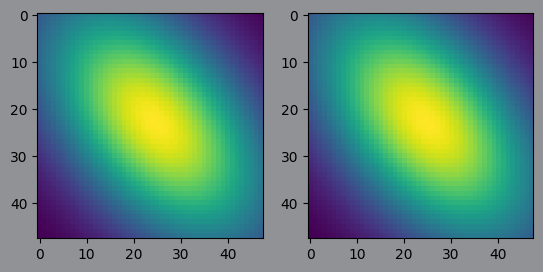

In [50]:
# Unquantized Gaussian

predicted_gaussian_labels = np.array(model(generated_gaussians_images)) * std_params + avg_params
predicted_gaussians_images = generate_guassian(tf.convert_to_tensor(generated_gaussians_labels, dtype=tf.float32), (48,48))

rand_int = np.random.randint(low=0, high=num_generated_gaussians)
print(f'[Gaussian_Model MSE]: {mean_squared_error(generated_gaussians_labels, predicted_gaussian_labels)}')
print(f'[Gaussian_Model MAE]: {mean_absolute_error(generated_gaussians_labels, predicted_gaussian_labels)}')
print(f'[True Label #{rand_int}]:      {generated_gaussians_labels[rand_int]}')
print(f'[Predicted Label #{rand_int}]: {predicted_gaussian_labels[rand_int]}')

plt.subplot(1, 2, 1)
plt.imshow(generated_gaussians_images[rand_int])
plt.subplot(1, 2, 2)
plt.imshow(predicted_gaussians_images[rand_int])
plt.show()


In [19]:
# Quantized Gaussian
save_qmodel = NO
view_qstats = NO
symmetric = YES
val = 16

loss_arr = []
for i in range(1, val + 1):
    for j in range(i + 1):
        integer = j
        total_bits = i
        Quantized_Gaussian_Model_file = Gaussian_Model_dir + f'Gaussian_Model_{total_bits}_{integer}.keras'

        q_dict = {
            "QConv2D": {
                "kernel_quantizer": f"quantized_bits({total_bits},{integer},{symmetric})",
                "bias_quantizer": f"quantized_bits({total_bits},{integer},{symmetric})"
            },
            "QDense": {
                "kernel_quantizer": f"quantized_bits({total_bits},{integer},{symmetric})",
                "bias_quantizer": f"quantized_bits({total_bits},{integer},{symmetric})"
            },
            "QBatchNormalization": {},

            "QActivation": f"quantized_relu({total_bits},{integer})"
        }

        qmodel = model_quantize(model, q_dict, total_bits, transfer_weights=True)


        if save_qmodel:
            qmodel.save(Quantized_Gaussian_Model_file)

        if view_qstats:
            print_qstats(qmodel)

        qpredicted_gaussian_labels = np.array(qmodel(generated_gaussians_images)) * std_params + avg_params
        loss_arr.append((total_bits, 
                         integer, 
                         mean_squared_error(generated_gaussians_labels, qpredicted_gaussian_labels),
                         mean_absolute_error(generated_gaussians_labels, qpredicted_gaussian_labels)))
        
loss_arr = np.array(loss_arr)

In [21]:
print("Total Bits | Integer | MSE | MAE")
print(loss_arr[loss_arr[:, 2].argsort()][:10])

Total Bits | Integer | MSE | MAE
[[ 4.          4.          3.3553566   1.18342453]
 [15.         15.          3.4199571   1.21799255]
 [10.         10.          3.43988339  1.21849377]
 [11.         11.          3.44143442  1.22354035]
 [16.         16.          3.44461948  1.19633472]
 [12.         12.          3.44542402  1.22001182]
 [ 8.          8.          3.45446923  1.21605373]
 [ 9.          9.          3.45573943  1.21991165]
 [13.         13.          3.48015438  1.22742157]
 [ 7.          7.          3.51665531  1.2302899 ]]


In [22]:
print("Total Bits | Integer | MSE | MAE")
print(loss_arr[loss_arr[:, 3].argsort()][:10])

Total Bits | Integer | MSE | MAE
[[ 4.          4.          3.3553566   1.18342453]
 [16.         16.          3.44461948  1.19633472]
 [ 8.          8.          3.45446923  1.21605373]
 [15.         15.          3.4199571   1.21799255]
 [10.         10.          3.43988339  1.21849377]
 [ 9.          9.          3.45573943  1.21991165]
 [12.         12.          3.44542402  1.22001182]
 [ 5.          5.          3.59448106  1.22023834]
 [11.         11.          3.44143442  1.22354035]
 [13.         13.          3.48015438  1.22742157]]


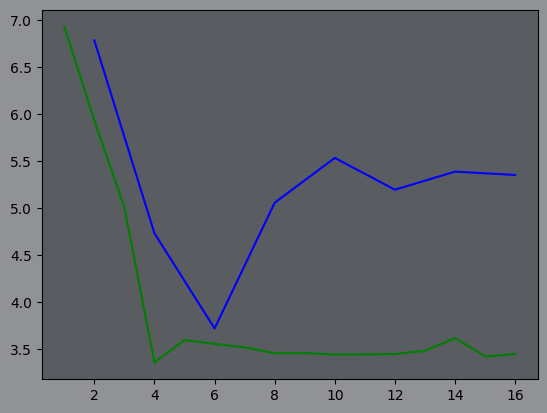

In [54]:
plot_elements = loss_arr[loss_arr[:, 0] == loss_arr[:, 1]]
plt.plot(plot_elements[:, 0], plot_elements[:, 2], color='green')
plot_elements = loss_arr[loss_arr[:, 0] == 2 * loss_arr[:, 1]]
plt.plot(plot_elements[:, 0], plot_elements[:, 2], color='blue')
plt.show()

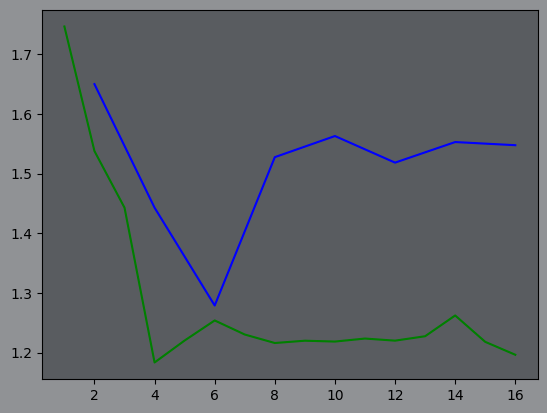

In [55]:
plot_elements = loss_arr[loss_arr[:, 0] == loss_arr[:, 1]]
plt.plot(plot_elements[:, 0], plot_elements[:, 3], color='green')
plot_elements = loss_arr[loss_arr[:, 0] == 2 * loss_arr[:, 1]]
plt.plot(plot_elements[:, 0], plot_elements[:, 3], color='blue')
plt.show()